# Imports
Make sure to run `pip install -r requirements.txt` before running this notebook.

In [1]:
import sys
import os
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax

import matplotlib.pyplot as plt
import optax

from typing import Any, Callable, Sequence, Optional, Union

key = jax.random.PRNGKey(0)

In [2]:
# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# importing the analyzer class
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.ntk_analyzer import NTKAnalyzer
from util.helper import create_mlp_stax, create_mlp_stax_2

# Generate data

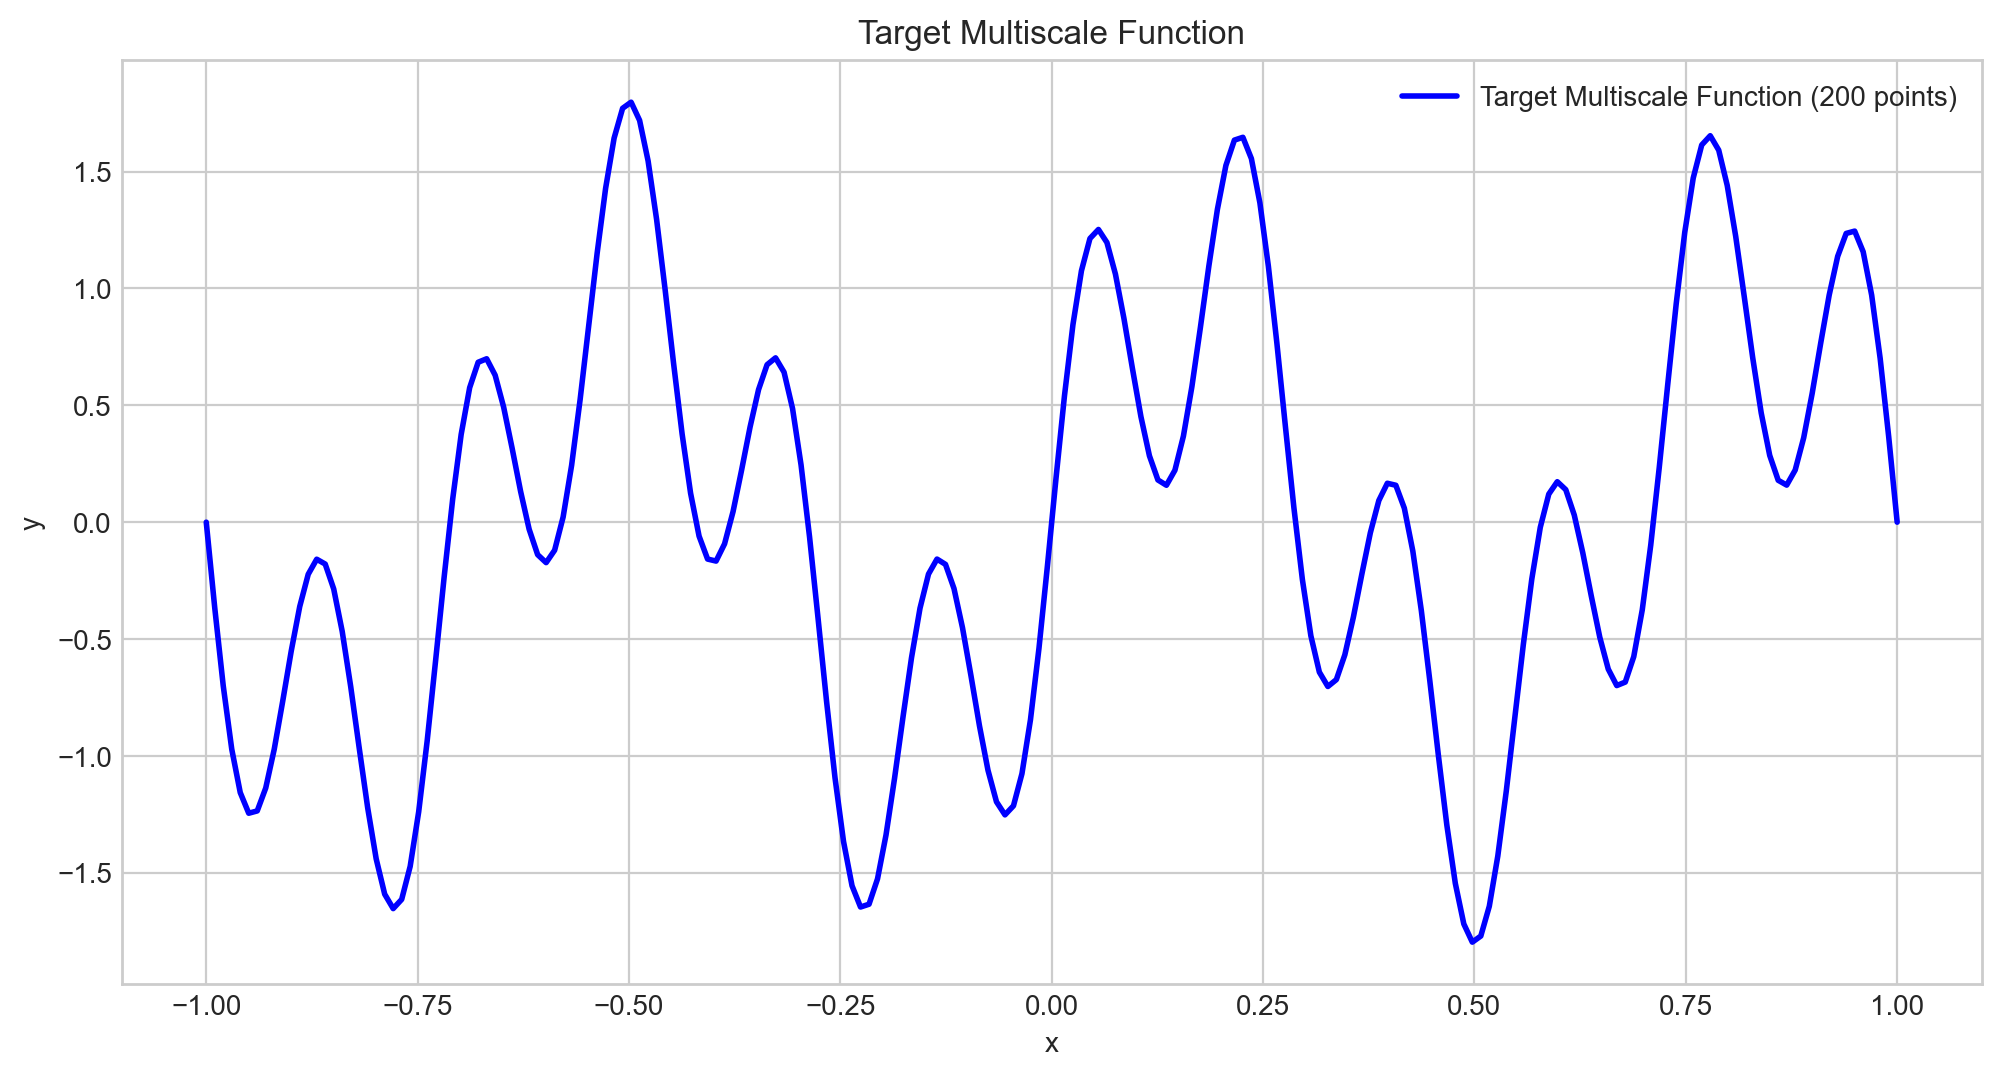

X_train shape: (200, 1), Y_train shape: (200, 1)


In [4]:
key_data_gen, key_sample = jax.random.split(key, 2)
key = key_data_gen 

N_TRAIN_SAMPLES = 200

X_domain_min = -1
X_domain_max = 1

X_train = jnp.linspace(X_domain_min, X_domain_max, N_TRAIN_SAMPLES)[:, None]
Y_train = jnp.sin(3 * jnp.pi * X_train) + 0.8 * jnp.sin(11 * jnp.pi * X_train)
# perm = jax.random.permutation(key, X_train.shape[0])
# X_train = X_train[perm]
# Y_train = Y_train[perm]

X_test = jnp.linspace(X_domain_min - 0.1, X_domain_max + 0.1, 400)[:, None] 
Y_test_true = jnp.sin(3 * jnp.pi * X_test) + 0.8 * jnp.sin(11 * jnp.pi * X_test)

INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = Y_train.shape[1]

sorted_idx = jnp.argsort(X_train[:, 0])
X_sorted = X_train[sorted_idx]
Y_sorted = Y_train[sorted_idx]

plt.figure(figsize=(12, 6))
plt.plot(X_sorted, Y_sorted, label=f'Target Multiscale Function ({N_TRAIN_SAMPLES} points)', color='blue', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.title('Target Multiscale Function')
plt.grid(True)
plt.show()

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")

# Define Network Architecture and Initialize


Network Architecture: InputDim=1, HiddenLayers=6, HiddenWidth=4, OutputDim=1
Layer widths for NTKAnalyzer: [1, 4, 4, 4, 4, 4, 4, 1]
Activation function: (<function _elementwise.<locals>.<lambda> at 0x304648040>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x30b1cf380>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x30b1cfc40>)


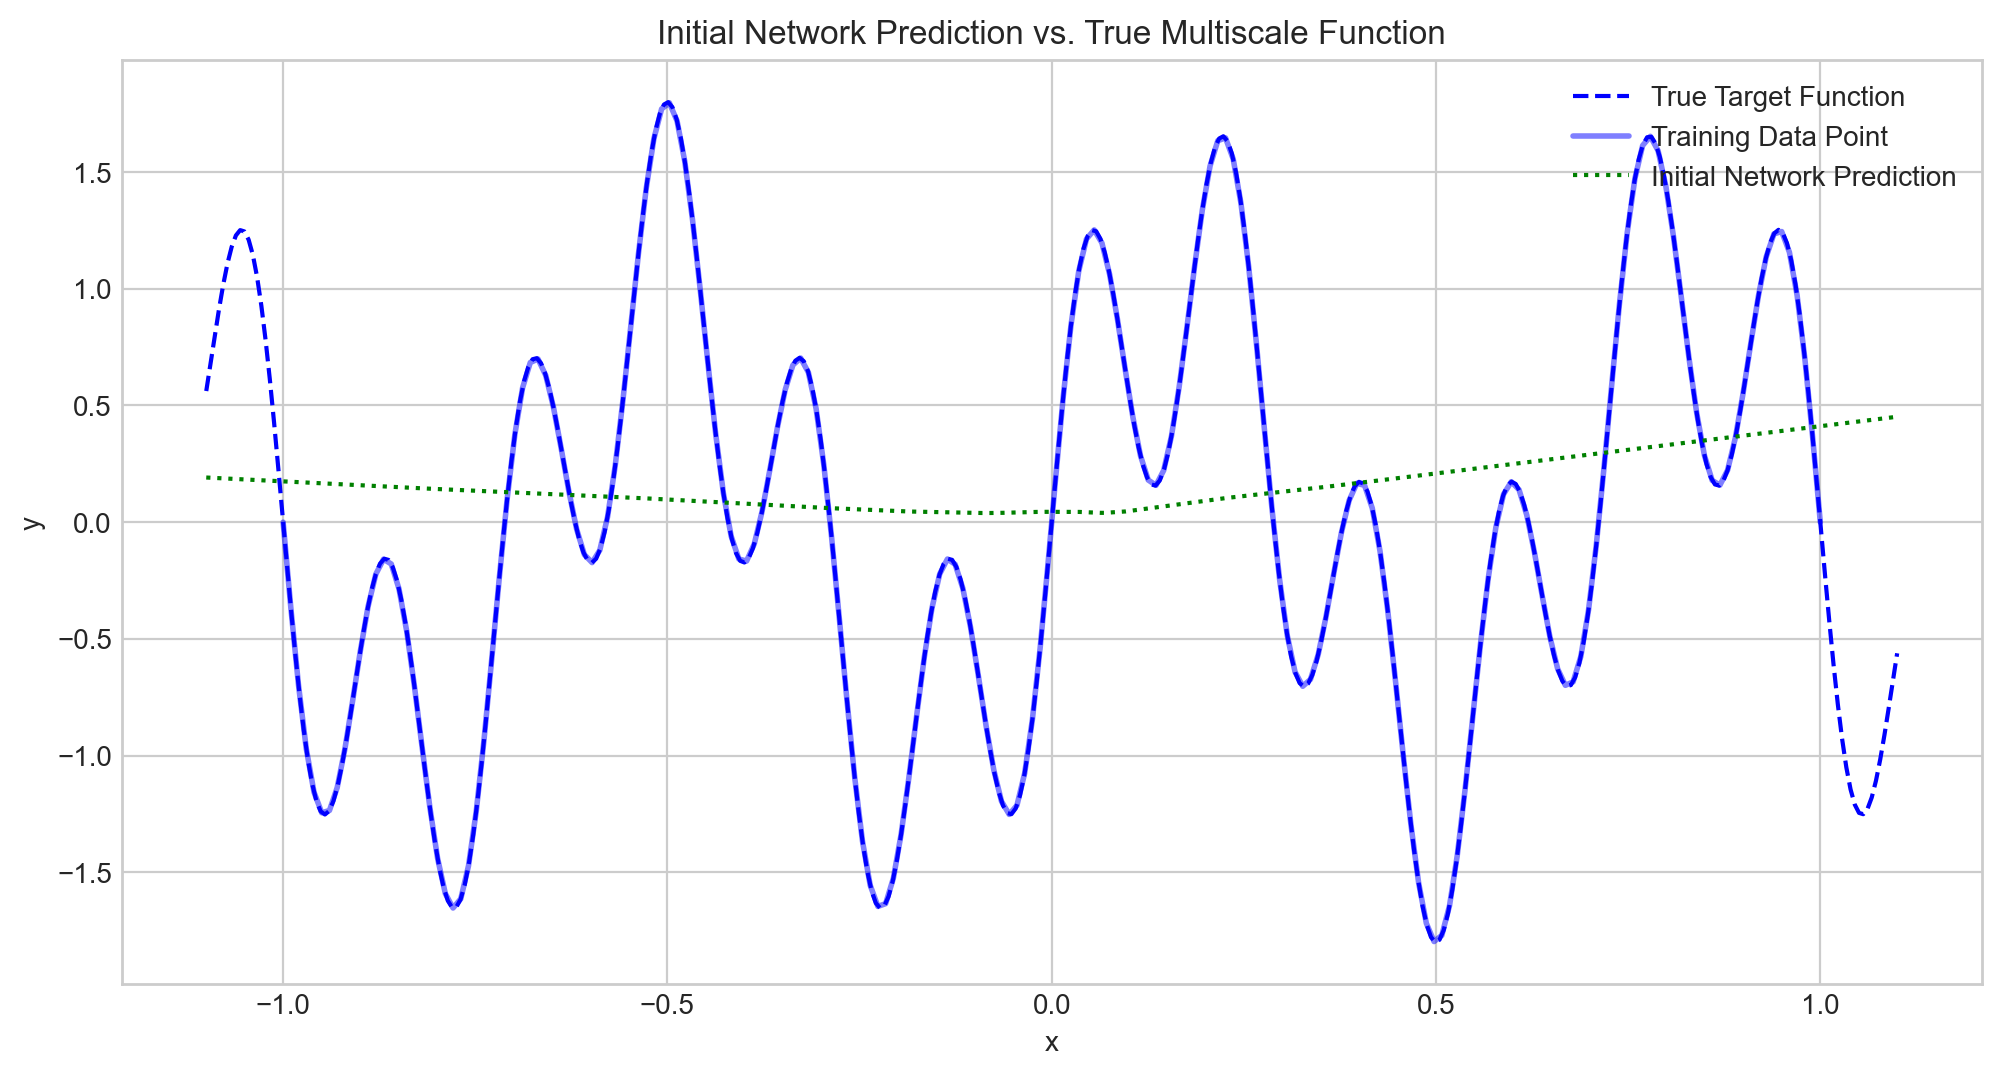

In [60]:
key, init_key = jax.random.split(key)

HIDDEN_LAYERS = 6      
HIDDEN_WIDTH = 4  
ACTIVATION_FN_STAX = stax.Relu() 

# for init of weights
W_STD = jnp.sqrt(2)            
B_STD = 0.05

init_fn, net_apply_fn, net_stax_kernel_fn = create_mlp_stax(
    depth=HIDDEN_LAYERS, 
    hidden_width=HIDDEN_WIDTH,
    output_dim=OUTPUT_DIM,
    activation_stax_fn=ACTIVATION_FN_STAX,
    W_std=W_STD,
    b_std=B_STD
)

layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * HIDDEN_LAYERS + [OUTPUT_DIM]

_, params_initial = init_fn(init_key, (-1, INPUT_DIM)) 

print(f"\nNetwork Architecture: InputDim={INPUT_DIM}, HiddenLayers={HIDDEN_LAYERS}, HiddenWidth={HIDDEN_WIDTH}, OutputDim={OUTPUT_DIM}")
print(f"Layer widths for NTKAnalyzer: {layer_widths_spec}")
print(f"Activation function: {ACTIVATION_FN_STAX}")

Y_pred_initial = net_apply_fn(params_initial, X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, Y_test_true, label='True Target Function', color='blue', linestyle='--')
plt.plot(X_sorted, Y_sorted, label=f'Training Data Point', color='blue', alpha=0.5,linewidth=2)
plt.plot(X_test, Y_pred_initial, label='Initial Network Prediction', color='green', linestyle=':')
plt.title('Initial Network Prediction vs. True Multiscale Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Initialize NTKAnalyzer and Analyze at Initialization

In [61]:
analyzer_initial = NTKAnalyzer(
    apply_fn=net_apply_fn, 
    params=params_initial,
    depth=HIDDEN_LAYERS, 
    widths=layer_widths_spec
)

beta_value = analyzer_initial.get_beta()
print(f"Calculated Beta (sum 1/n_j for hidden layers): {beta_value if beta_value is not None else 'N/A'}")

Calculated Beta (sum 1/n_j for hidden layers): 1.5



--- Initial Empirical NTK Analysis (on 200 training points) ---
Shape of Empirical NTK K(X,X): (200, 200, 1, 1)


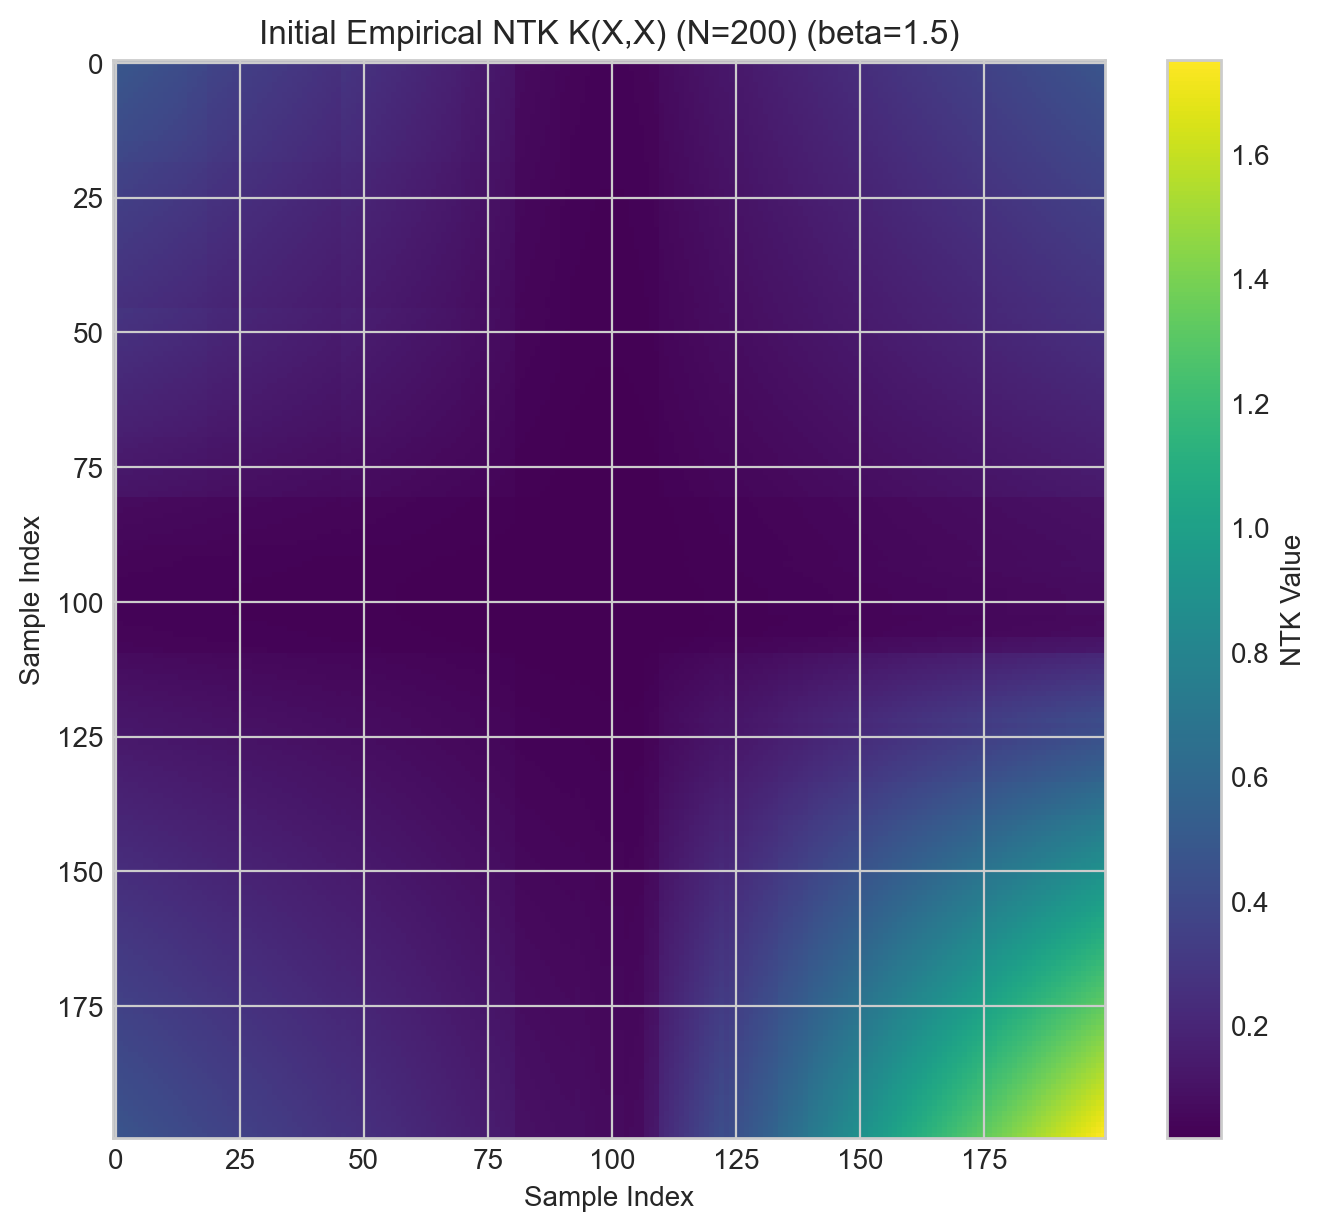

In [62]:
X_ntk_analysis = X_train 

print(f"\n--- Initial Empirical NTK Analysis (on {X_ntk_analysis.shape[0]} training points) ---")
ntk_empirical_initial = analyzer_initial.compute_ntk_dataset(X_ntk_analysis, X_ntk_analysis)
print(f"Shape of Empirical NTK K(X,X): {ntk_empirical_initial.shape}")

# Squeeze the NTK matrix if it has trailing singleton dimensions for plotting
ntk_plot_initial = ntk_empirical_initial
if ntk_empirical_initial.ndim == 4 and ntk_empirical_initial.shape[-1] == 1 and ntk_empirical_initial.shape[-2] == 1:
    ntk_plot_initial = ntk_empirical_initial.squeeze(axis=(-1, -2))
elif ntk_empirical_initial.ndim == 3 and ntk_empirical_initial.shape[-1] == 1 : # Should not happen with current NTKAnalyzer
    ntk_plot_initial = ntk_empirical_initial.squeeze(axis=-1)

plt.figure(figsize=(8,7))
plt.imshow(ntk_plot_initial, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='NTK Value')
plt.title(f'Initial Empirical NTK K(X,X) (N={X_ntk_analysis.shape[0]}) (beta={beta_value})')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

## Comparing initial NTK of different betas


Network Architecture: InputDim=1, HiddenLayers=256, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 2.0


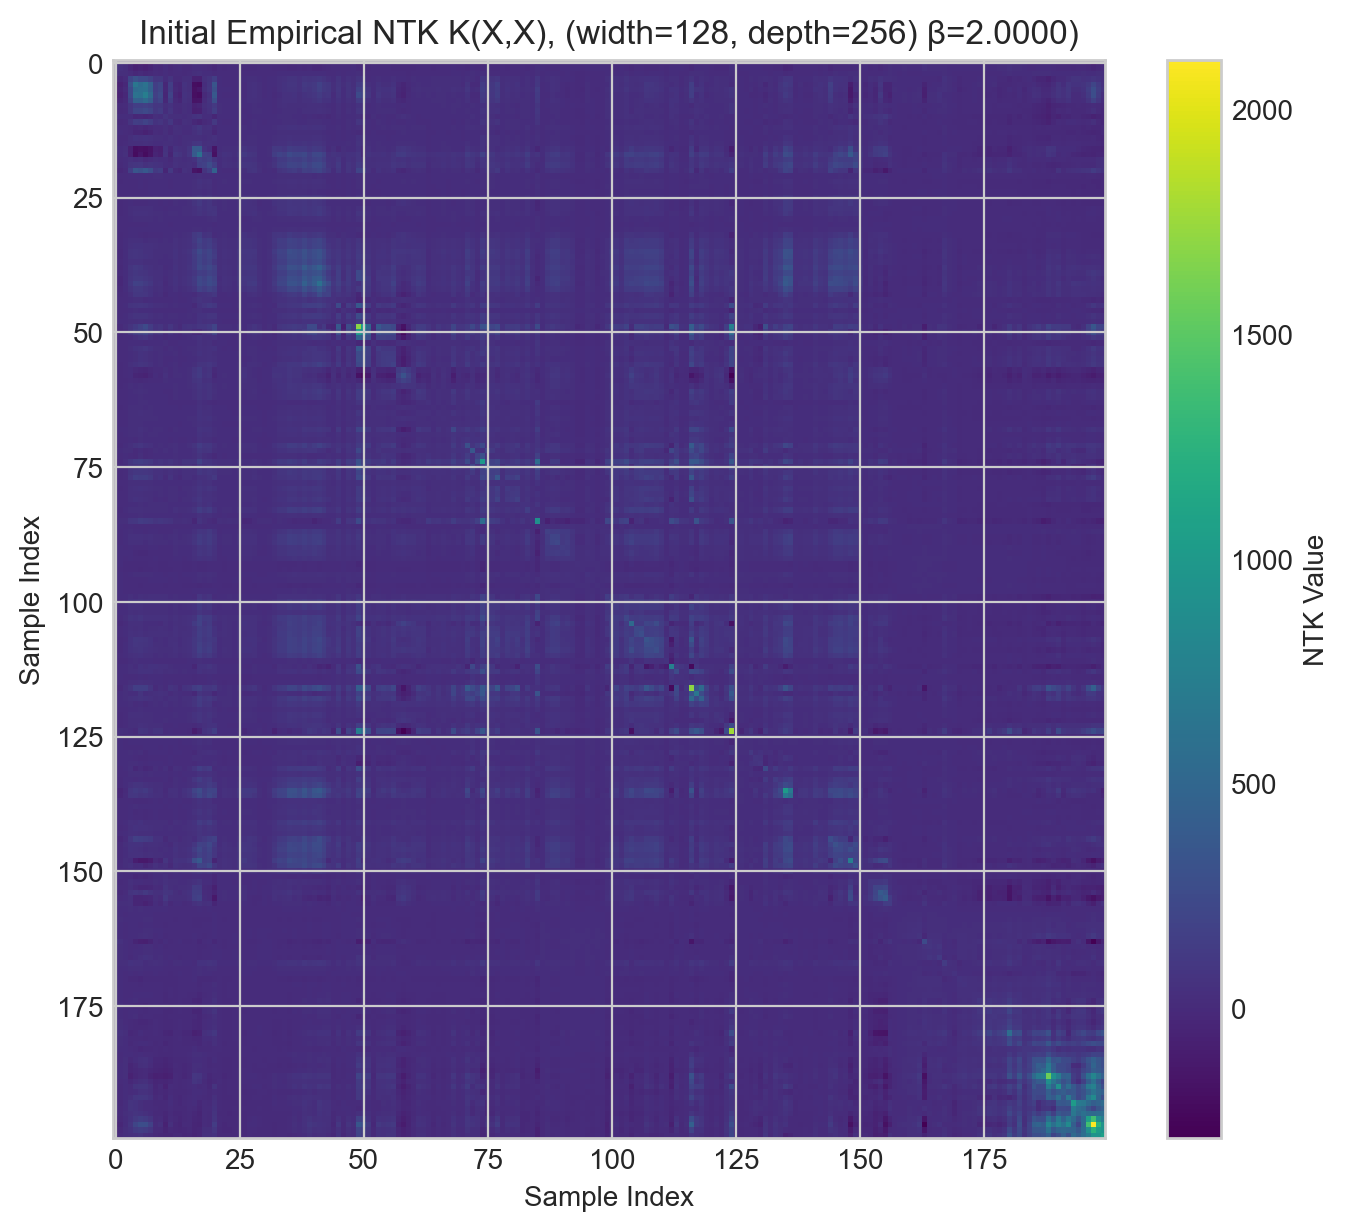


Network Architecture: InputDim=1, HiddenLayers=200, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 1.5625


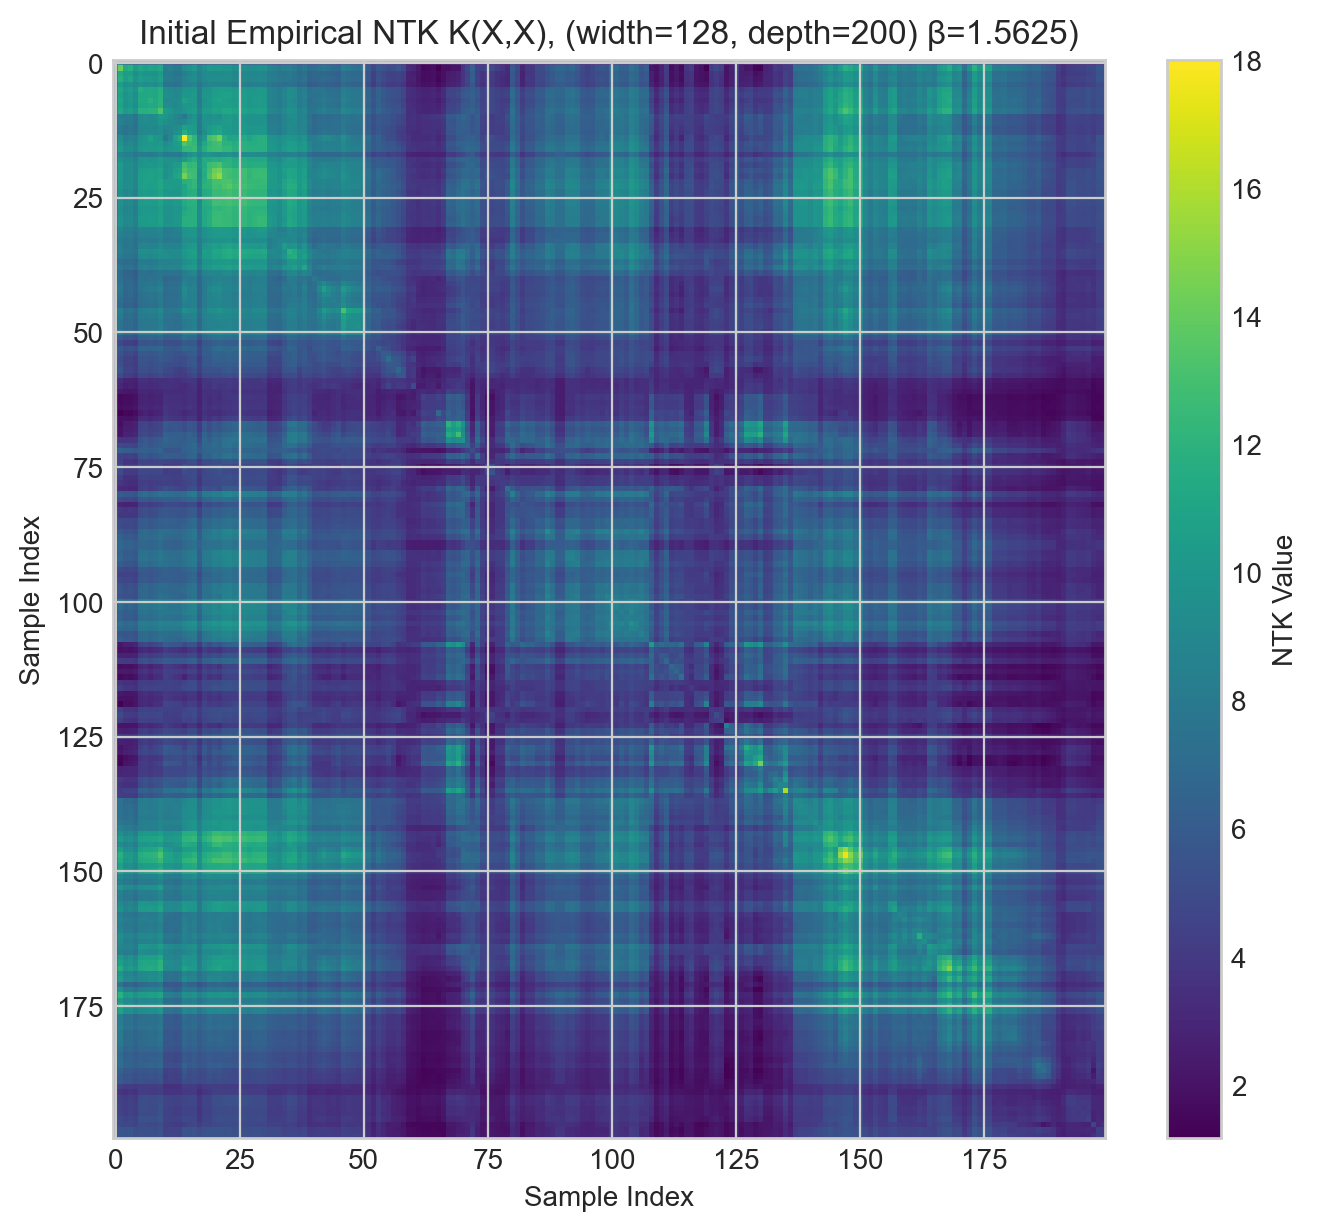


Network Architecture: InputDim=1, HiddenLayers=180, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 1.40625


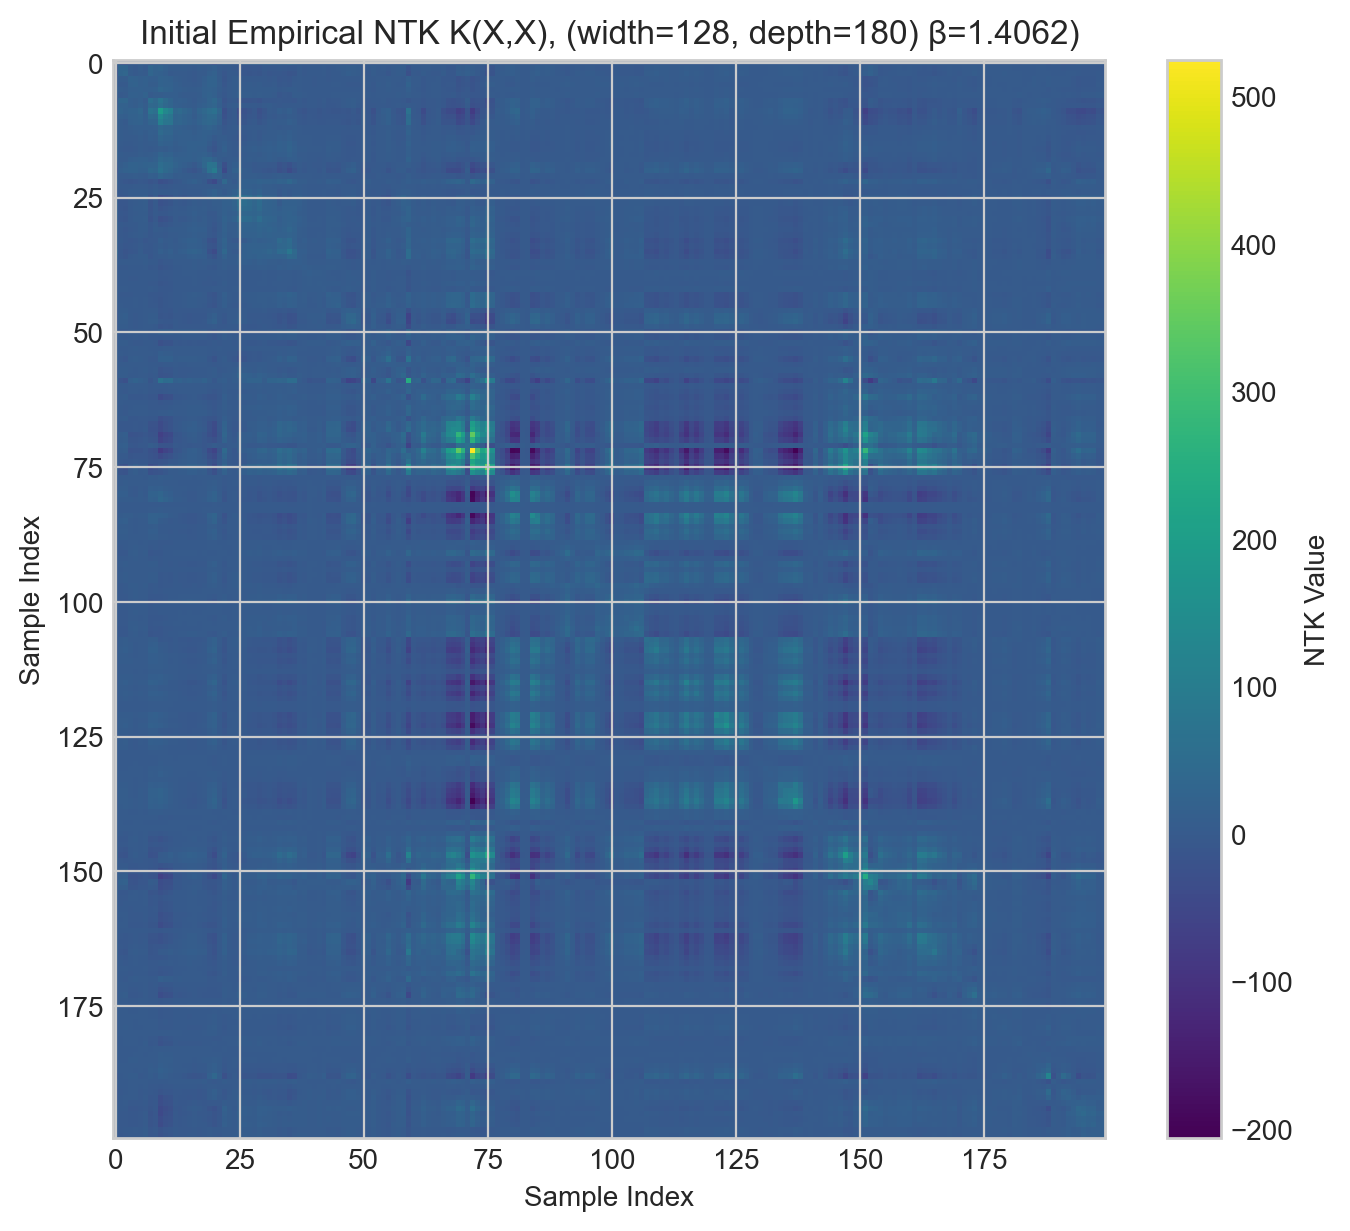


Network Architecture: InputDim=1, HiddenLayers=50, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 0.390625


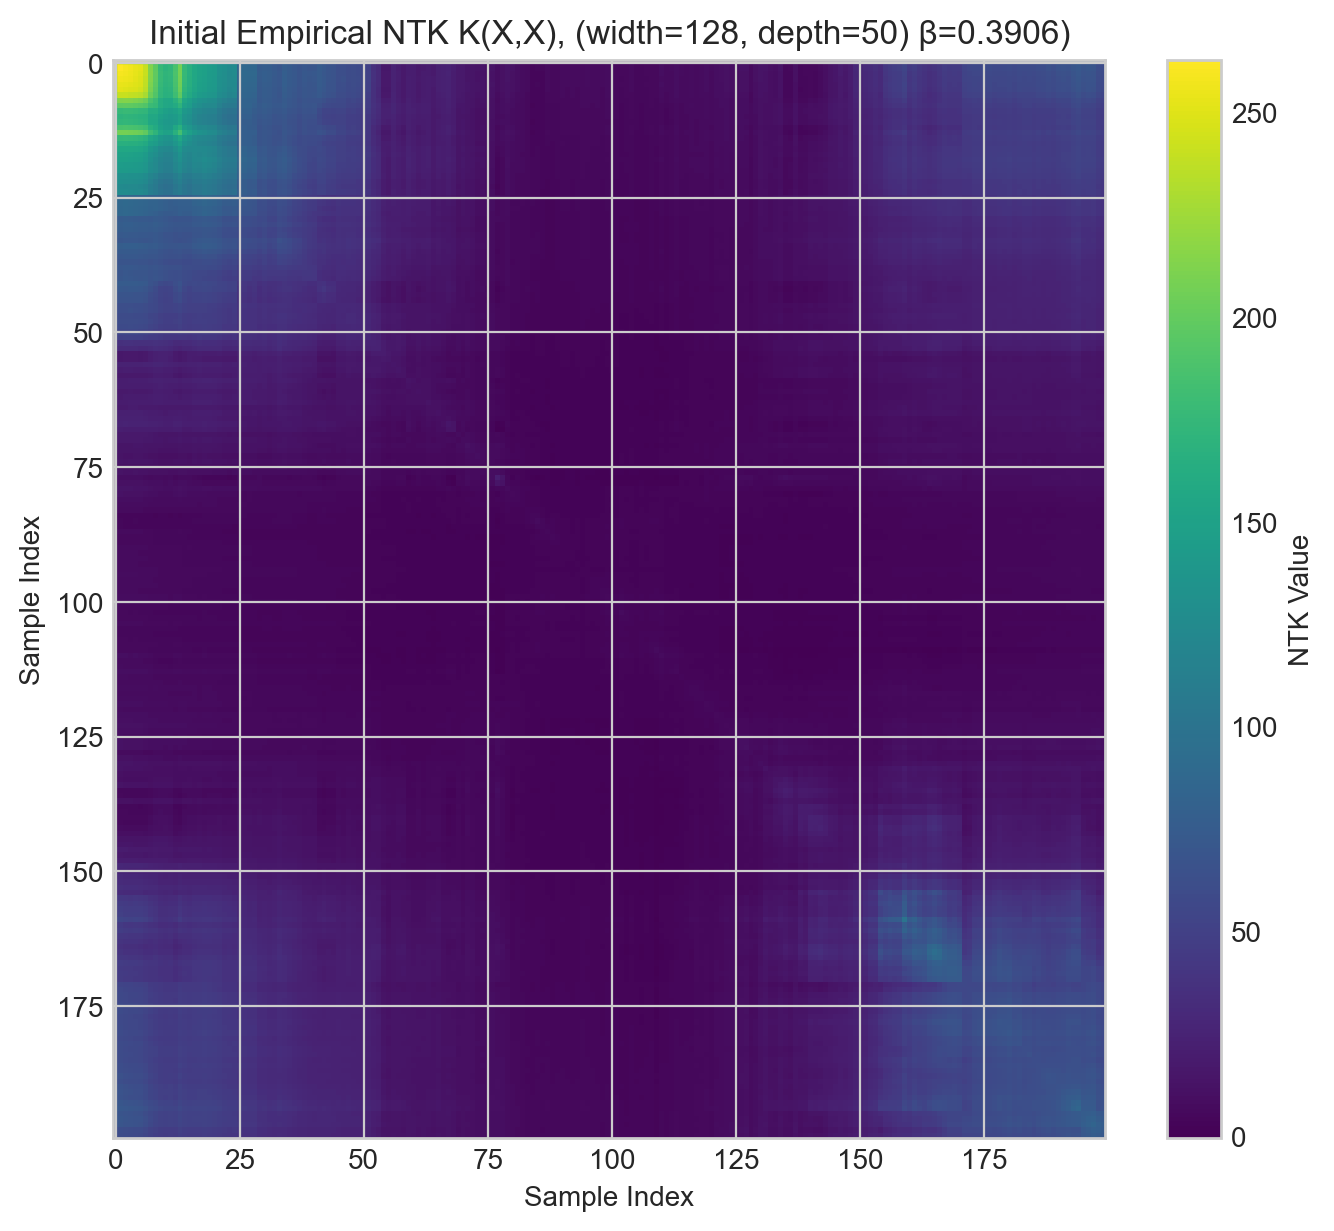


Network Architecture: InputDim=1, HiddenLayers=10, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 0.078125


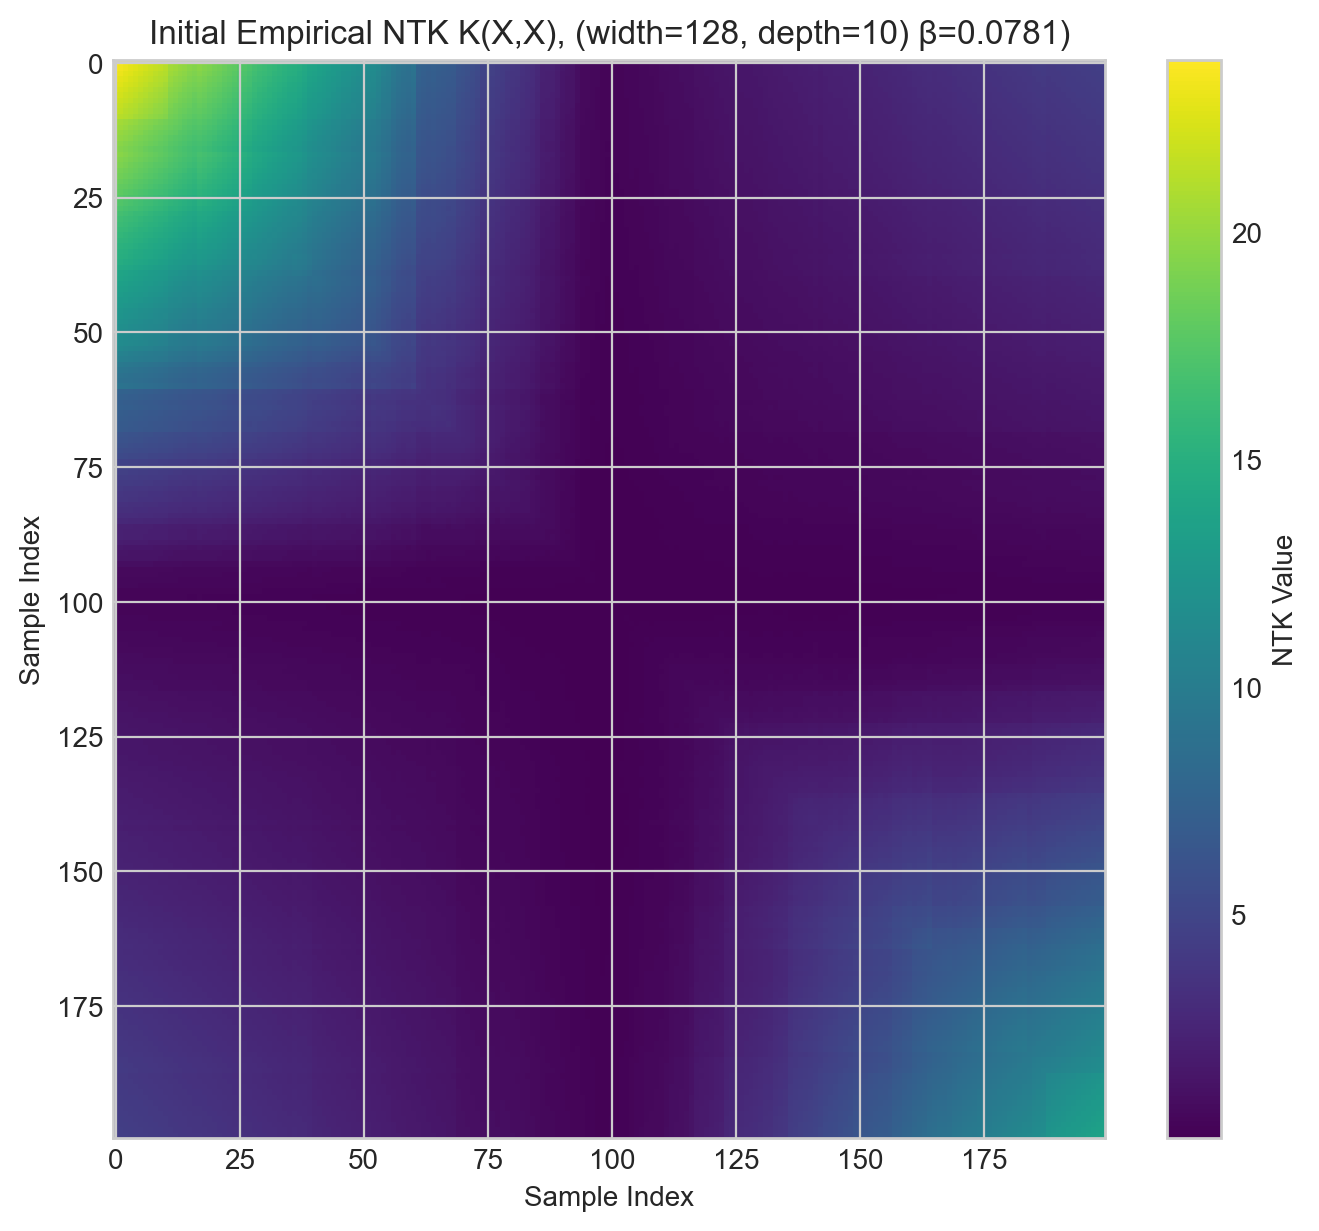


Network Architecture: InputDim=1, HiddenLayers=2, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 0.015625


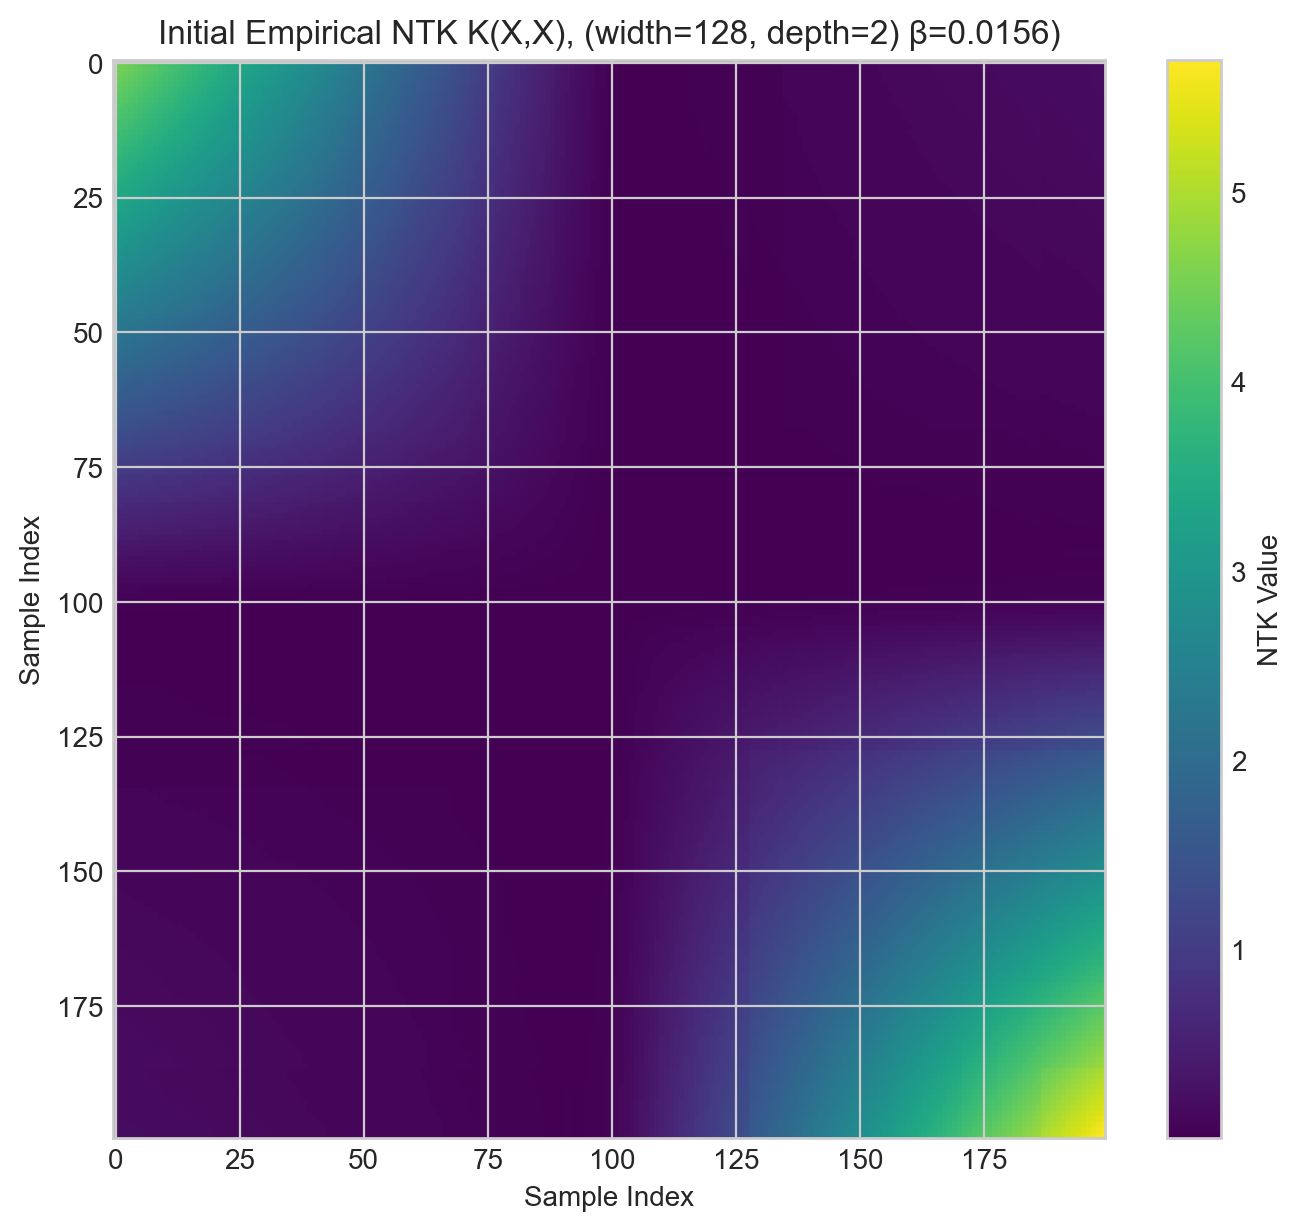


Network Architecture: InputDim=1, HiddenLayers=1, HiddenWidth=128, OutputDim=1
Activation function: (<function _elementwise.<locals>.<lambda> at 0x36ecbdc60>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x36ecbe0c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x36ecbe840>)
Calculated Beta (sum 1/n_j for hidden layers): 0.0078125


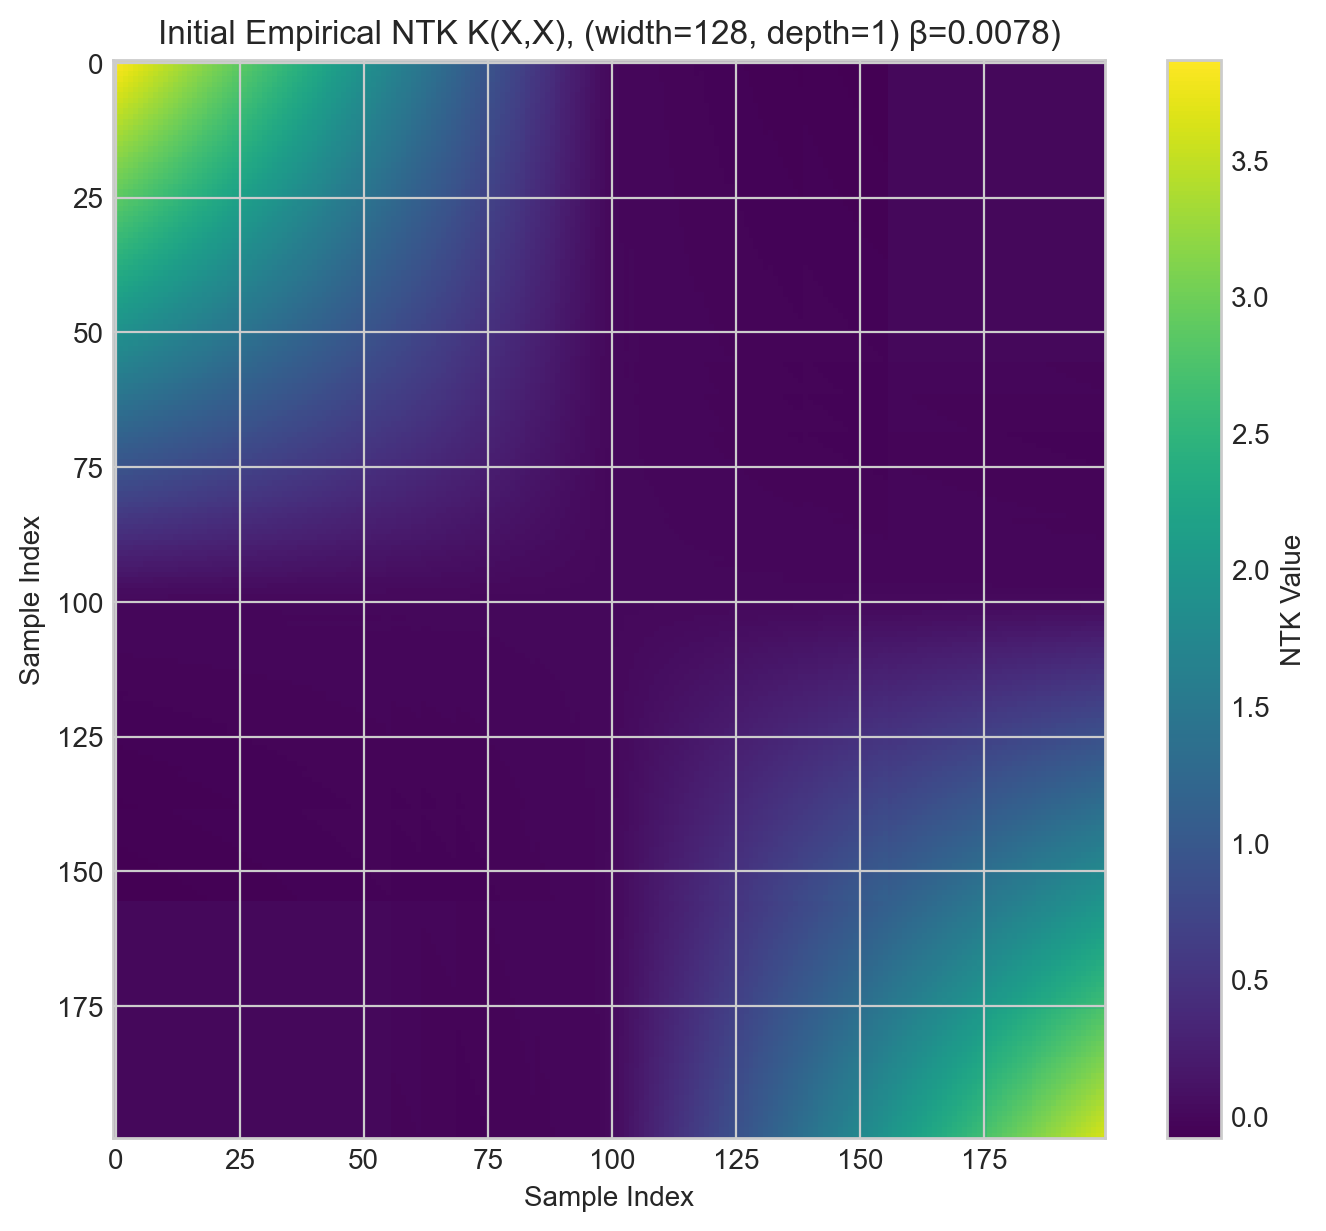

In [11]:
depths = [256, 200,180,50,10,2,1]  
HIDDEN_WIDTH = 128   
ACTIVATION_FN_STAX = stax.Relu()  
W_STD = jnp.sqrt(2)  
B_STD = 0.05      
X_ntk_analysis = X_train

for depth in depths:
    init_fn, net_apply_fn, net_stax_kernel_fn = create_mlp_stax(
        depth=depth,
        hidden_width=HIDDEN_WIDTH,
        output_dim=OUTPUT_DIM,
        activation_stax_fn=ACTIVATION_FN_STAX,
        W_std=W_STD,
        b_std=B_STD
    )
    key, init_key = jax.random.split(key)
    _, params_initial = init_fn(init_key, (-1, INPUT_DIM))

    layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * depth + [OUTPUT_DIM]

    print(f"\nNetwork Architecture: InputDim={INPUT_DIM}, HiddenLayers={depth}, HiddenWidth={HIDDEN_WIDTH}, OutputDim={OUTPUT_DIM}")
    print(f"Activation function: {ACTIVATION_FN_STAX}")

    analyzer_initial = NTKAnalyzer(
        apply_fn=net_apply_fn,
        params=params_initial,
        depth=depth,
        widths=layer_widths_spec
    )

    beta_value = analyzer_initial.get_beta()
    print(f"Calculated Beta (sum 1/n_j for hidden layers): {beta_value if beta_value is not None else 'N/A'}")
    
    ntk_empirical_initial_db = analyzer_initial.compute_ntk_dataset(X_ntk_analysis, X_ntk_analysis)

    ntk_plot_initial = ntk_empirical_initial_db
    if ntk_empirical_initial_db.ndim == 4 and ntk_empirical_initial_db.shape[-1] == 1 and ntk_empirical_initial_db.shape[-2] == 1:
        ntk_plot_initial = ntk_empirical_initial_db.squeeze(axis=(-1, -2))
    elif ntk_empirical_initial_db.ndim == 3 and ntk_empirical_initial_db.shape[-1] == 1:
        ntk_plot_initial = ntk_empirical_initial_db.squeeze(axis=-1)

    plt.figure(figsize=(8, 7))
    plt.imshow(ntk_plot_initial, cmap='viridis', aspect='auto', interpolation='nearest')
    plt.colorbar(label='NTK Value')
    plt.title(f'Initial Empirical NTK K(X,X), (width={HIDDEN_WIDTH}, depth={depth}) β={beta_value:.4f})')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.show()

Number of eigenvalues (initial): 200
Top 5 eigenvalues (initial, largest first): [132.40111     32.05844      4.2564287    1.4182171    0.43435055]
Condition Number (initial): 8.7644e+08


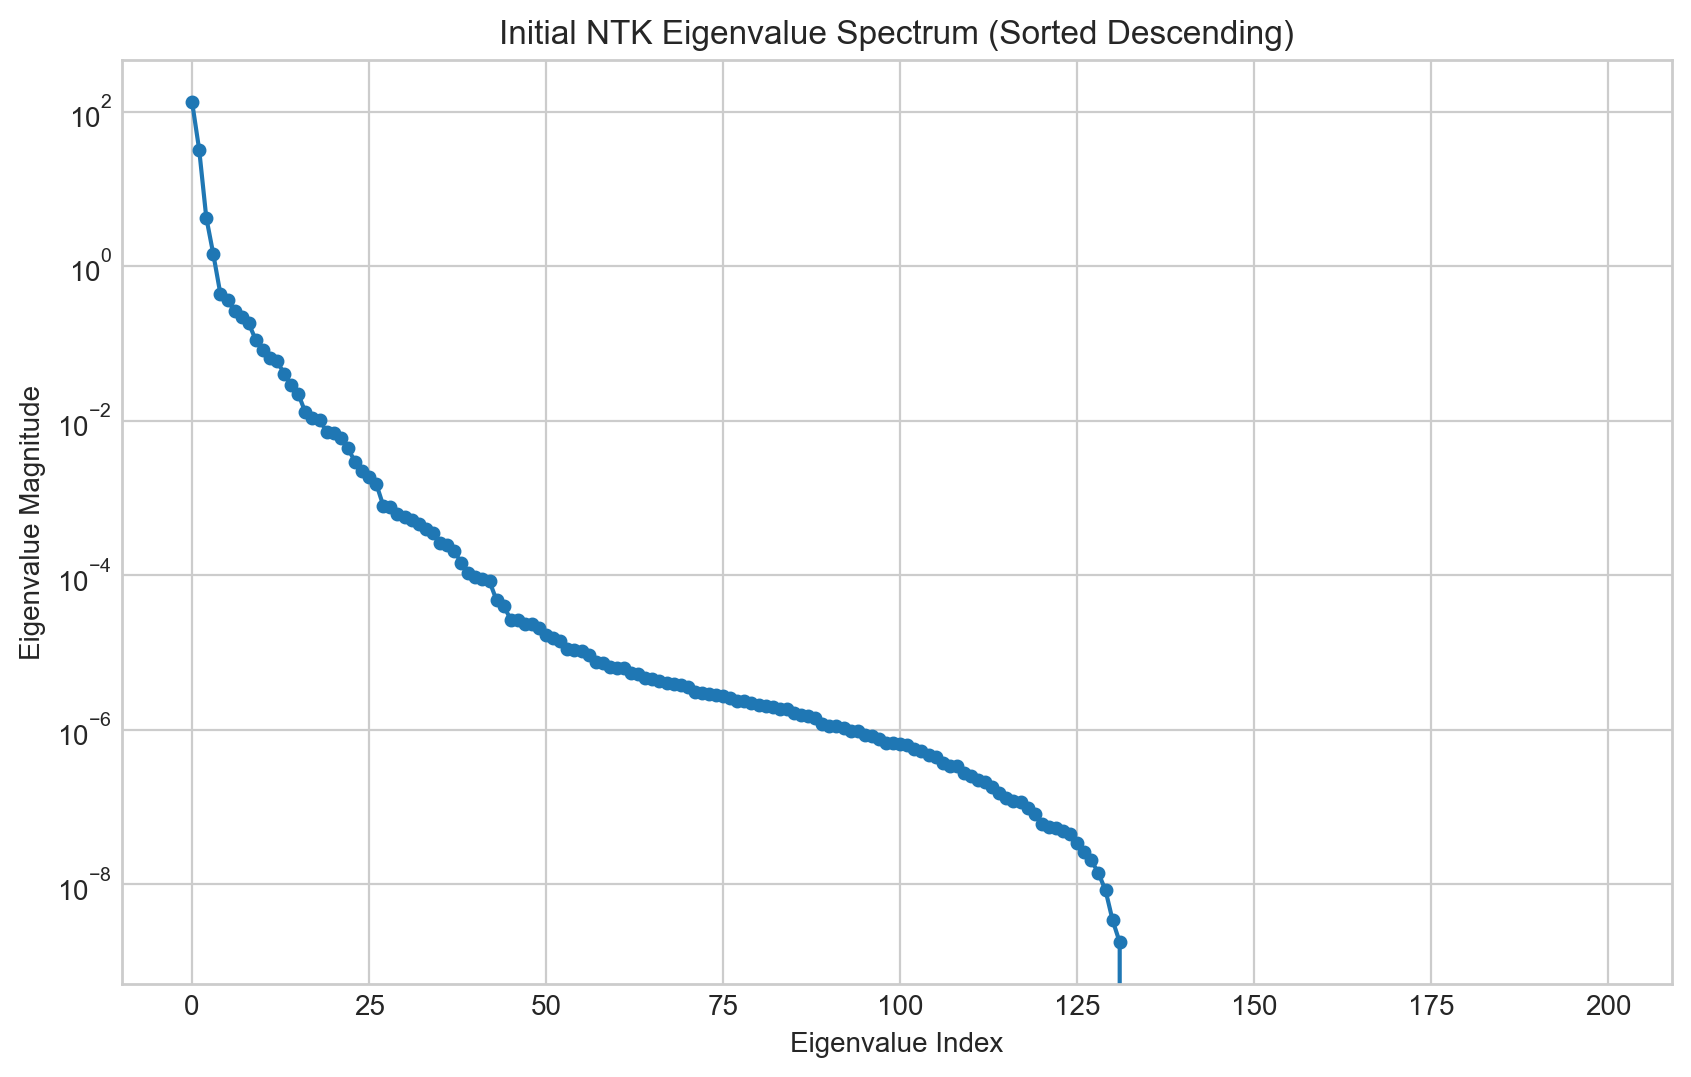


--- Infinite-Width NTK Analysis (on Training Data) ---
Shape of Infinite-Width NTK K_inf(X,X): (200, 200)


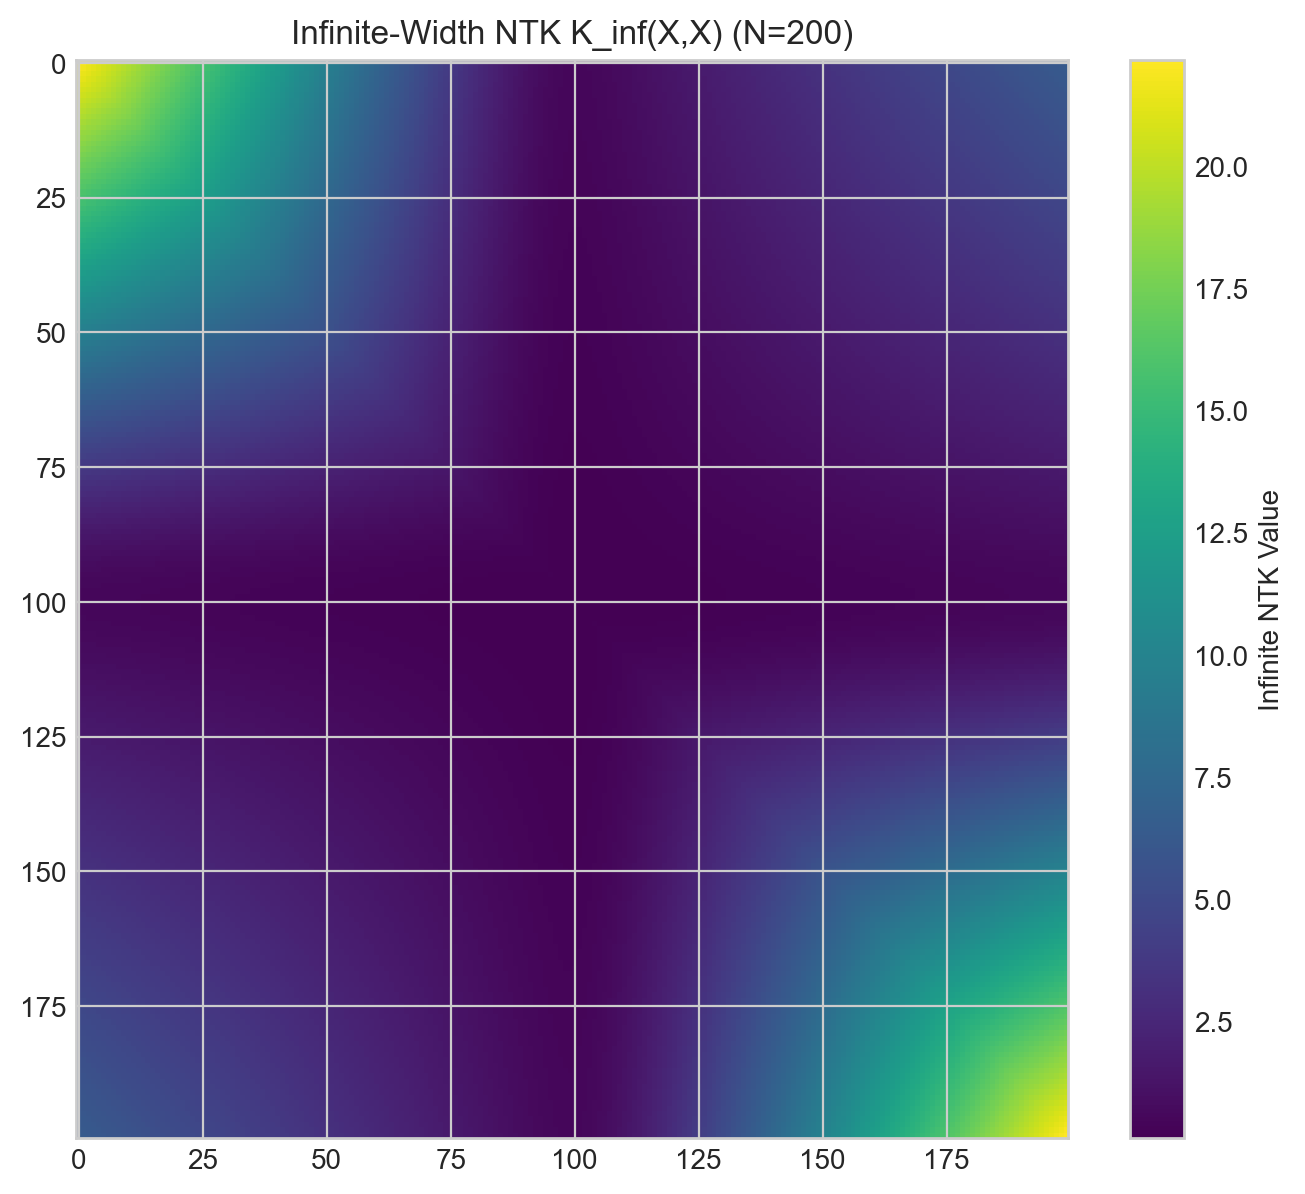

Frobenius norm of difference (Empirical_init - Infinite NTK): 200964.2344
Top 5 eigenvalues (infinite NTK): [921.56104  483.74036   26.942188  24.077782   9.738683]
Condition Number (infinite NTK): 9.5087e+04

--- Initial NTK Diagonal Properties (on Training Data) ---
Mean of K(x_i, x_i)_00 (initial): 0.8604
Std Dev of K(x_i, x_i)_00 (initial): 1.0425
Variance of K(x_i, x_i)_00 (initial): 1.0868
Relative Std Dev (Std/Mean) of K(x_i, x_i)_00: 1.2116


In [10]:
spectrum_method_choice = "trace" if OUTPUT_DIM == 1 else "full" 
try:
    eigenvalues_initial, _ = analyzer_initial.get_ntk_spectrum(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Number of eigenvalues (initial): {len(eigenvalues_initial)}")
    print(f"Top 5 eigenvalues (initial, largest first): {eigenvalues_initial[-5:][::-1]}")
    cond_num_initial = analyzer_initial.get_ntk_condition_number(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Condition Number (initial): {cond_num_initial:.4e}")

    plt.figure(figsize=(10,6))
    plt.plot(jnp.arange(len(eigenvalues_initial)), jnp.sort(eigenvalues_initial)[::-1], 'o-', markersize=4) 
    plt.title('Initial NTK Eigenvalue Spectrum (Sorted Descending)')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.yscale('log') 
    plt.grid(True, which="both", ls="-")
    plt.show()
except ValueError as e:
    print(f"Error computing initial spectrum: {e}")


print("\n--- Infinite-Width NTK Analysis (on Training Data) ---")
ntk_infinite = analyzer_initial.compute_infinite_ntk_dataset(
    X_ntk_analysis, X_ntk_analysis, kernel_fn=net_stax_kernel_fn # Pass the kernel_fn from stax
)
if ntk_infinite is not None:
    print(f"Shape of Infinite-Width NTK K_inf(X,X): {ntk_infinite.shape}")
    plt.figure(figsize=(8,7))
    plt.imshow(ntk_infinite, cmap='viridis', aspect='auto', interpolation='nearest')
    plt.colorbar(label='Infinite NTK Value')
    plt.title(f'Infinite-Width NTK K_inf(X,X) (N={X_ntk_analysis.shape[0]})')
    plt.show()

    diff_inf_emp_init = jnp.linalg.norm(ntk_empirical_initial - ntk_infinite)
    print(f"Frobenius norm of difference (Empirical_init - Infinite NTK): {diff_inf_emp_init:.4f}")
    
    eigenvalues_infinite, _ = jnp.linalg.eigh(ntk_infinite) 
    print(f"Top 5 eigenvalues (infinite NTK): {eigenvalues_infinite[-5:][::-1]}")
    abs_eig_inf = jnp.abs(eigenvalues_infinite)
    max_eig_inf = jnp.max(abs_eig_inf)
    # Ensure min_eig_inf_nz is not zero before division
    relevant_eig_inf = abs_eig_inf[abs_eig_inf > 1e-9 * max_eig_inf]
    min_eig_inf_nz = jnp.min(relevant_eig_inf) if relevant_eig_inf.size > 0 else 0.0
    cond_num_inf = jnp.inf if min_eig_inf_nz <= 1e-12 else (max_eig_inf / min_eig_inf_nz)
    print(f"Condition Number (infinite NTK): {cond_num_inf:.4e}")

else:
    print("Could not compute infinite-width NTK.")

print("\n--- Initial NTK Diagonal Properties (on Training Data) ---")
diag_per_output_initial = analyzer_initial.get_ntk_diagonal_per_output(X_ntk_analysis)
if diag_per_output_initial is not None:
    k_ii_initial = diag_per_output_initial[:, 0] 
    print(f"Mean of K(x_i, x_i)_00 (initial): {jnp.mean(k_ii_initial):.4f}")
    print(f"Std Dev of K(x_i, x_i)_00 (initial): {jnp.std(k_ii_initial):.4f}")
    print(f"Variance of K(x_i, x_i)_00 (initial): {jnp.var(k_ii_initial):.4f}")
    if jnp.mean(k_ii_initial) != 0:
        print(f"Relative Std Dev (Std/Mean) of K(x_i, x_i)_00: {(jnp.std(k_ii_initial) / jnp.mean(k_ii_initial)):.4f}")

# Train the network


--- Starting Training ---
Epoch 1/3000, Loss: 0.780251
Epoch 150/3000, Loss: 0.809852
Epoch 300/3000, Loss: 0.758638
Epoch 450/3000, Loss: 0.792577
Epoch 600/3000, Loss: 0.849395
Epoch 750/3000, Loss: 0.746738
Epoch 900/3000, Loss: 0.764919
Epoch 1050/3000, Loss: 0.796513
Epoch 1200/3000, Loss: 0.793835
Epoch 1350/3000, Loss: 0.729928
Epoch 1500/3000, Loss: 0.658978
Epoch 1650/3000, Loss: 0.541838
Epoch 1800/3000, Loss: 0.431086
Epoch 1950/3000, Loss: 0.432787
Epoch 2100/3000, Loss: 0.419923
Epoch 2250/3000, Loss: 0.400566
Epoch 2400/3000, Loss: 0.323228
Epoch 2550/3000, Loss: 0.342225
Epoch 2700/3000, Loss: 0.341503
Epoch 2850/3000, Loss: 0.292827
Epoch 3000/3000, Loss: 0.308677
--- Training Finished ---


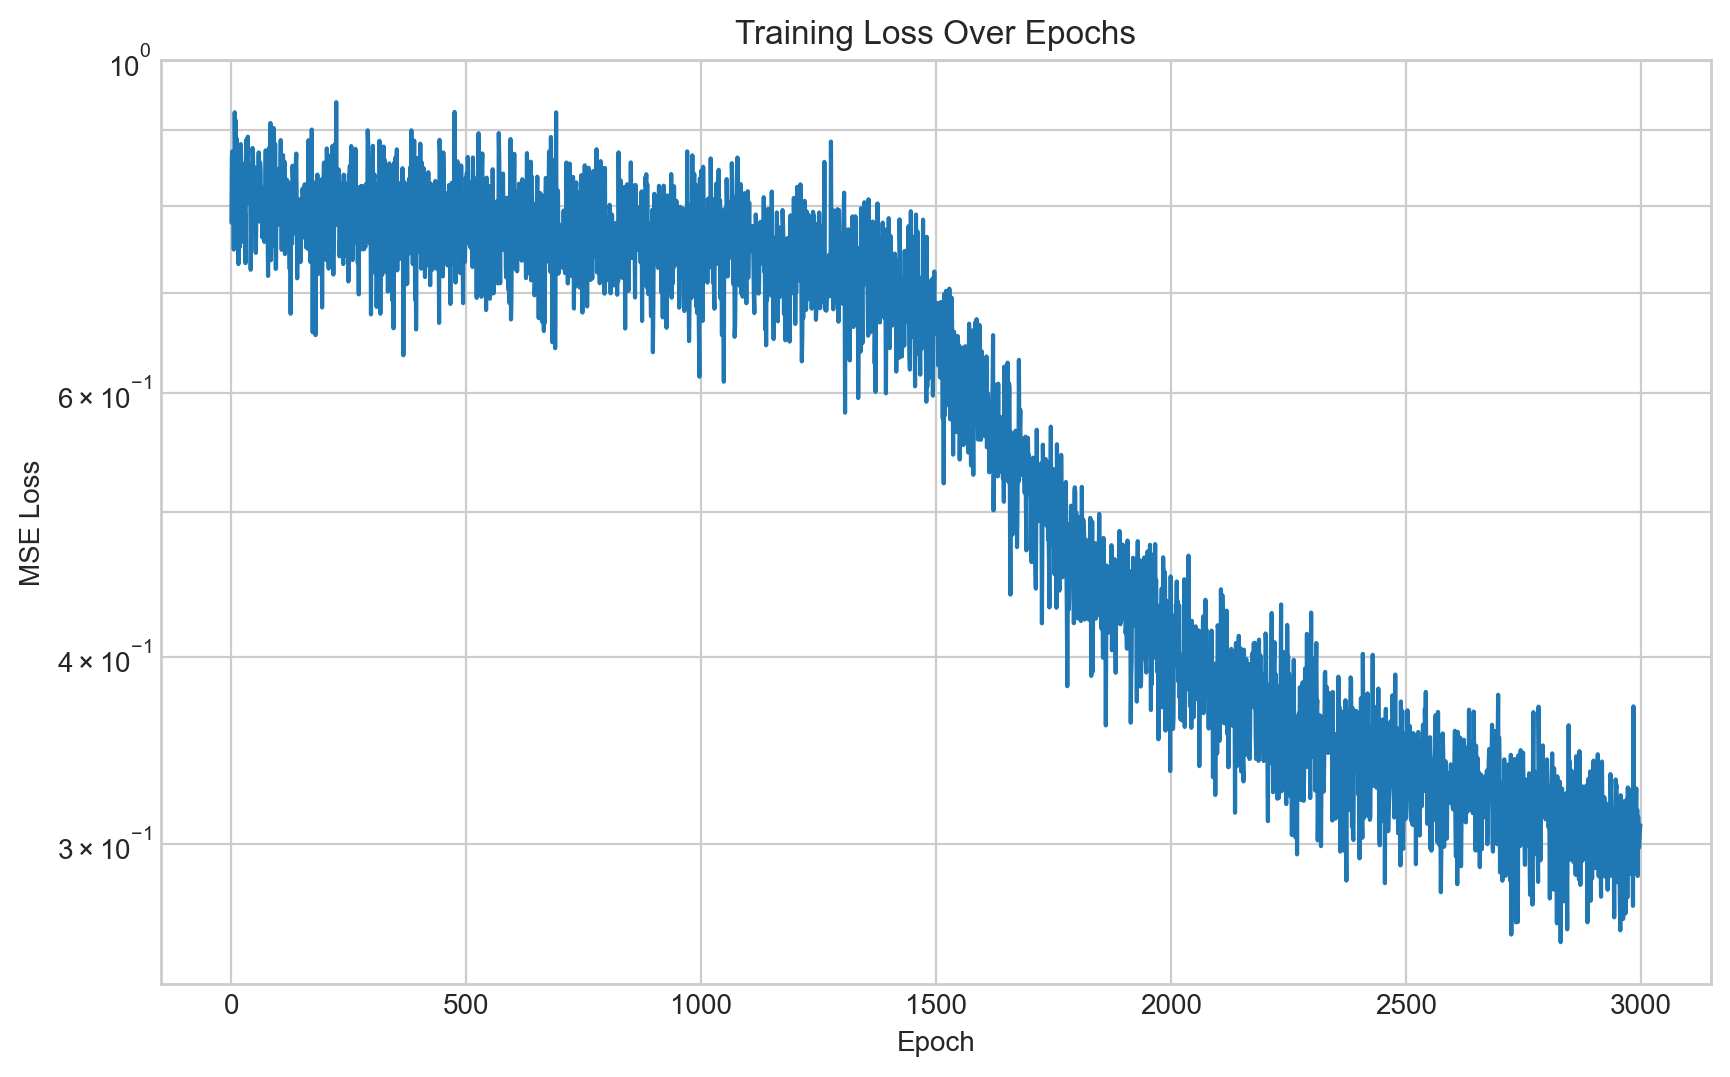

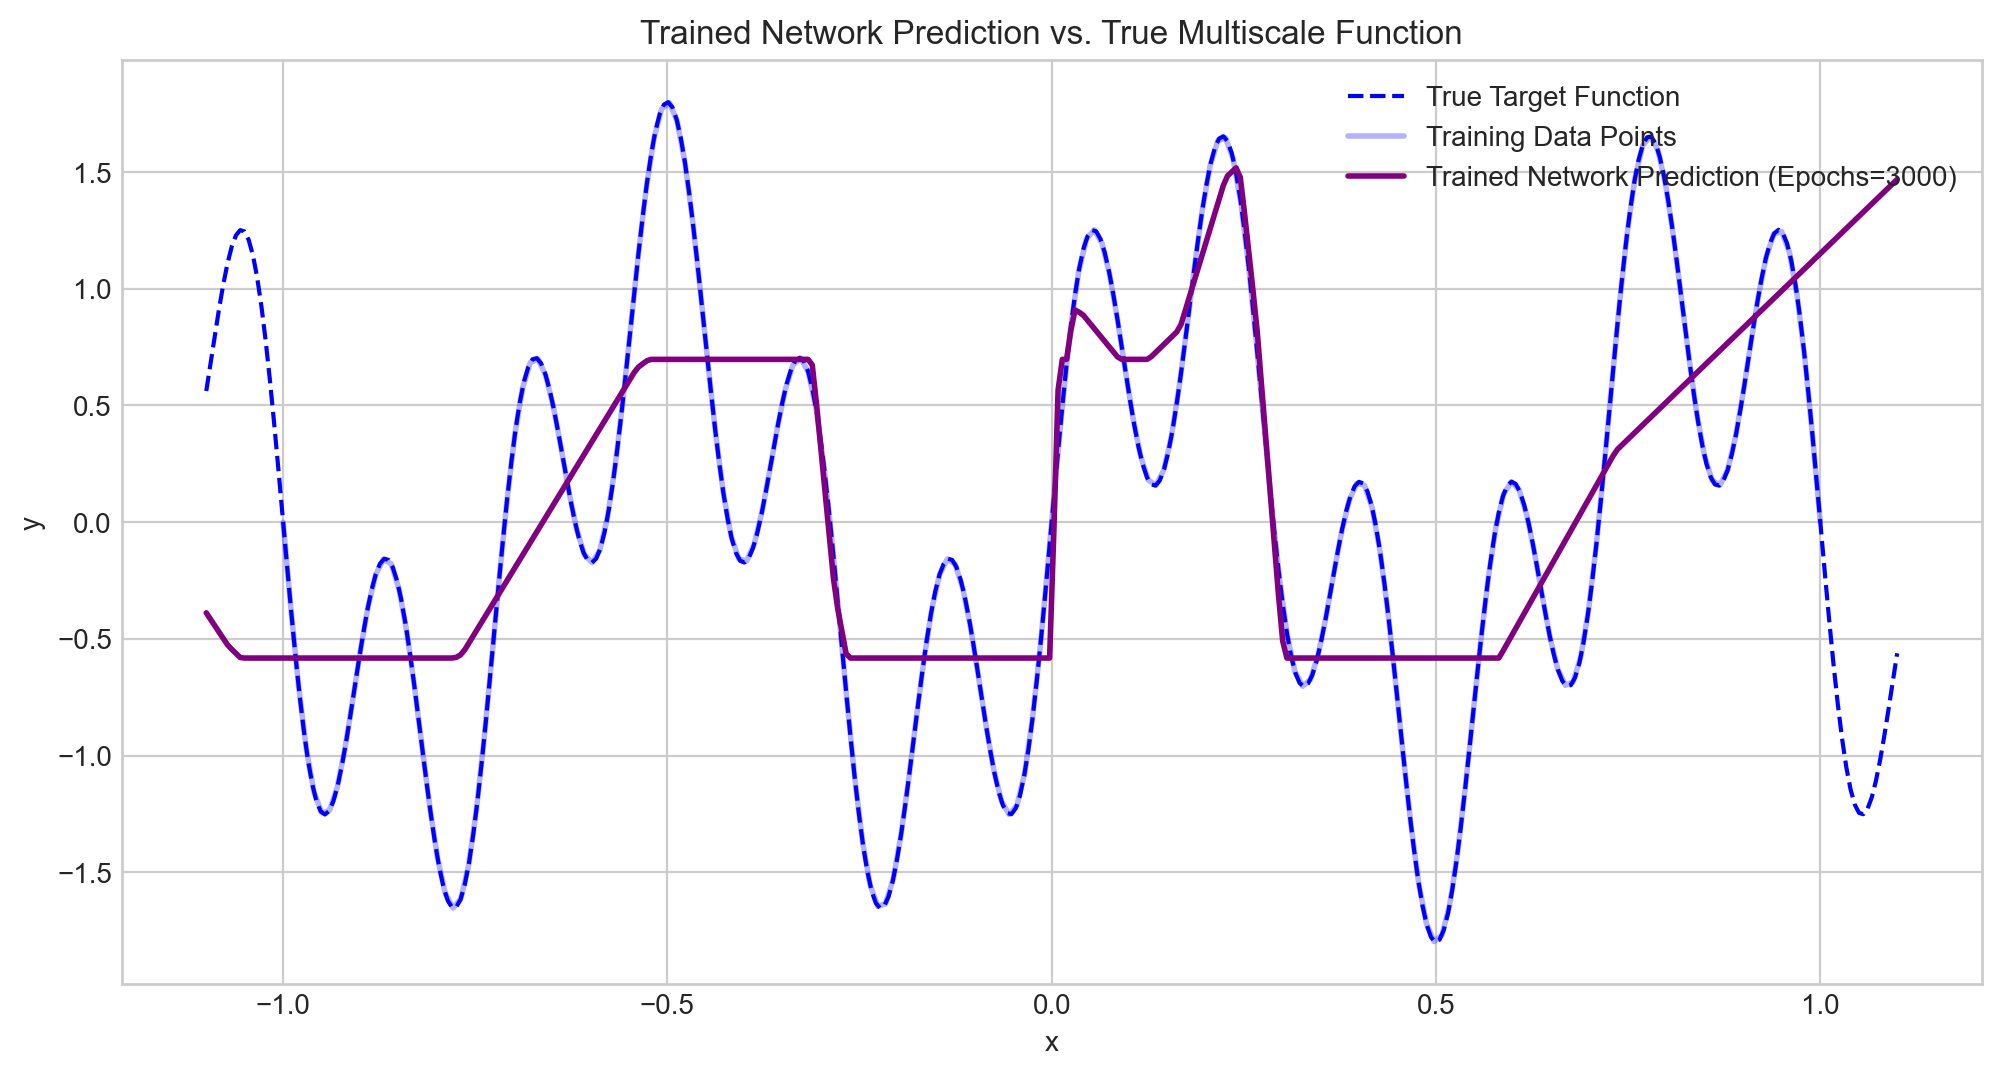

In [63]:
LEARNING_RATE = 1e-3  
EPOCHS = 3000         
BATCH_SIZE = 128      
PRINT_EVERY_EPOCHS = EPOCHS // 20

def mse_loss(params_current, x_batch, y_batch, apply_fn_local):
    y_pred = apply_fn_local(params_current, x_batch)
    if y_pred.shape != y_batch.shape:
        y_pred = y_pred.reshape(y_batch.shape)
    return jnp.mean((y_pred - y_batch)**2)

loss_fn_for_grad = jax.tree_util.Partial(mse_loss, apply_fn_local=net_apply_fn)

@jax.jit
def train_step(params_current, opt_state_current, x_batch, y_batch):
    loss_value, grads = jax.value_and_grad(loss_fn_for_grad)(params_current, x_batch, y_batch)
    updates, opt_state_new = optimizer.update(grads, opt_state_current, params_current)
    params_new = optax.apply_updates(params_current, updates)
    return params_new, opt_state_new, loss_value

optimizer = optax.adam(LEARNING_RATE)
opt_state_initial = optimizer.init(params_initial)

params_trained = params_initial
opt_state_trained = opt_state_initial
loss_history = []

print("\n--- Starting Training ---")
num_batches = N_TRAIN_SAMPLES // BATCH_SIZE if N_TRAIN_SAMPLES > BATCH_SIZE and BATCH_SIZE > 0 else 1

for epoch in range(EPOCHS):
    key, perm_key = jax.random.split(key) 
    
    if BATCH_SIZE > 0 and BATCH_SIZE < N_TRAIN_SAMPLES:
        perm = jax.random.permutation(perm_key, N_TRAIN_SAMPLES)
        shuffled_X_train = X_train[perm]
        shuffled_Y_train = Y_train[perm] 
        
        epoch_loss_sum = 0.0
        for i in range(num_batches):
            start = i * BATCH_SIZE
            end = start + BATCH_SIZE
            x_batch = shuffled_X_train[start:end]
            y_batch = shuffled_Y_train[start:end]
            params_trained, opt_state_trained, loss_val = train_step(params_trained, opt_state_trained, x_batch, y_batch)
            epoch_loss_sum += loss_val
        current_epoch_loss = (epoch_loss_sum / num_batches).item()
    else: 
        params_trained, opt_state_trained, loss_val = train_step(params_trained, opt_state_trained, X_train, Y_train)
        current_epoch_loss = loss_val.item()
    
    loss_history.append(current_epoch_loss)

    if (epoch + 1) % PRINT_EVERY_EPOCHS == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {current_epoch_loss:.6f}")

print("--- Training Finished ---")

plt.figure(figsize=(10,6))
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log') 
plt.grid(True, which="both", ls="-")
plt.show()

Y_pred_trained = net_apply_fn(params_trained, X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, Y_test_true, label='True Target Function', color='blue', linestyle='--')
plt.plot(X_sorted, Y_sorted, label='Training Data Points', color='blue', alpha=0.3, linewidth=2) 
plt.plot(X_test, Y_pred_trained, label=f'Trained Network Prediction (Epochs={EPOCHS})', color='purple', linewidth=2)
plt.title('Trained Network Prediction vs. True Multiscale Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Analysis after training


--- NTK Analysis After Training (on Training Data) ---
Shape of Empirical NTK K(X,X) (trained, raw): (200, 200, 1, 1)


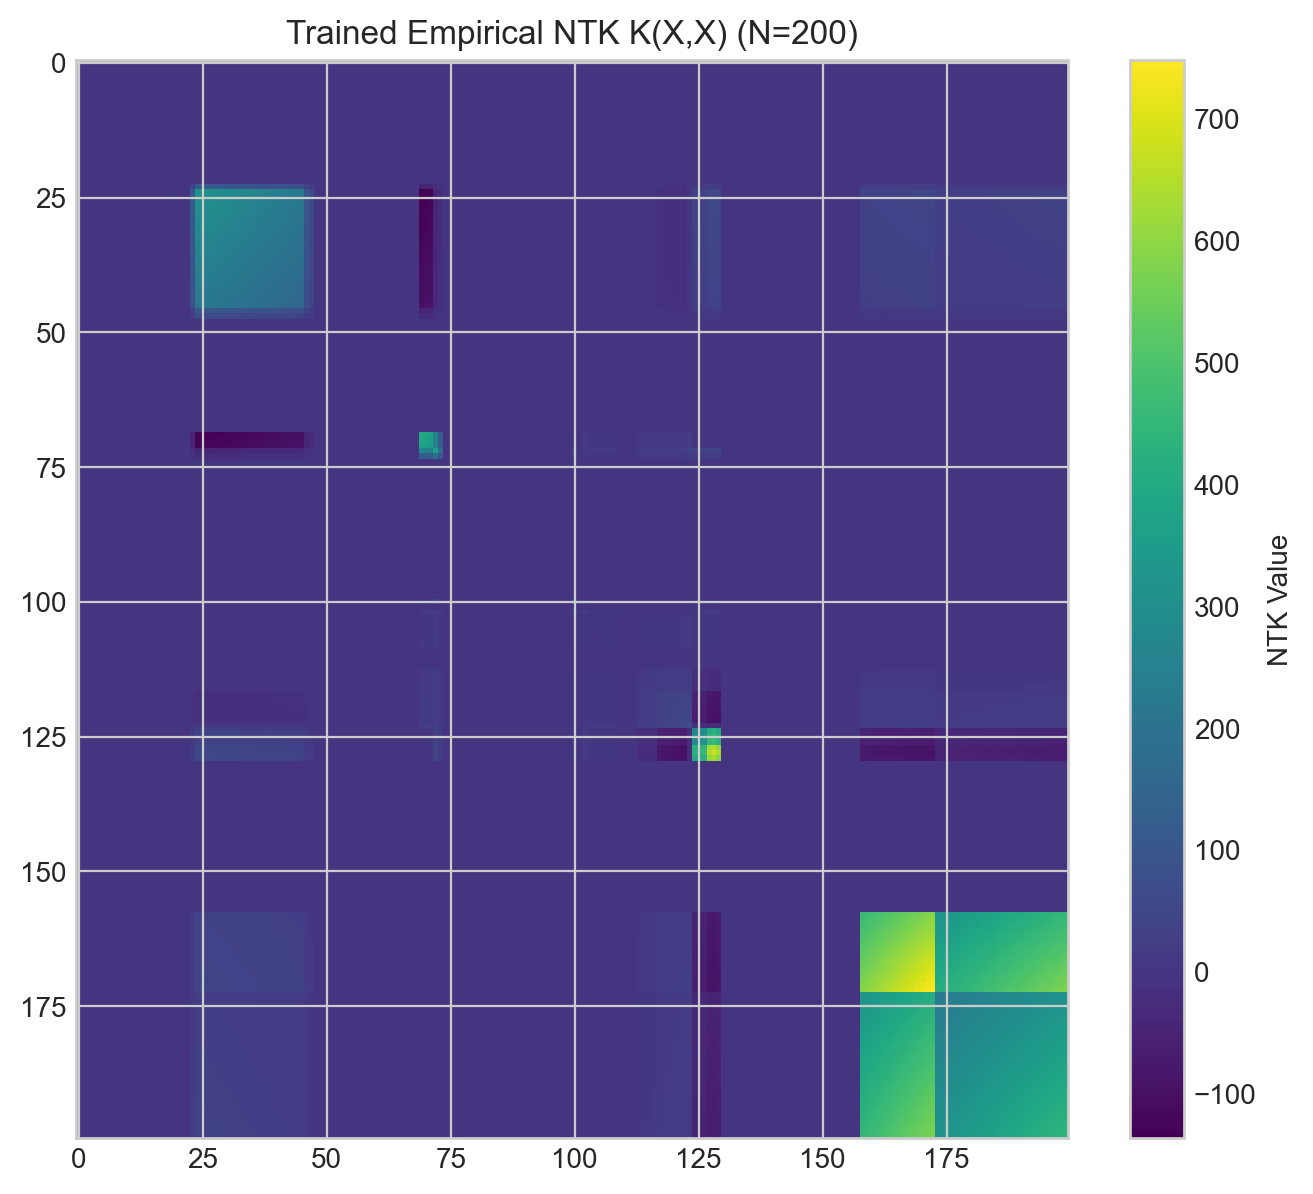

Frobenius norm of NTK change (||K_trained - K_initial||_fro): 19026.7930
An unexpected error occurred during trained spectrum analysis: name 'spectrum_method_choice' is not defined

--- Trained NTK Diagonal Properties (on Training Data) ---
Mean of K(x_i, x_i)_00 (trained): 139.8987
Std Dev of K(x_i, x_i)_00 (trained): 199.2315
Variance of K(x_i, x_i)_00 (trained): 39693.1914
Relative Std Dev (Std/Mean) of K(x_i, x_i)_00 (trained): 1.4241


In [64]:
print("\n--- NTK Analysis After Training (on Training Data) ---")

analyzer_initial.update_params(params_trained) 

ntk_empirical_trained_raw = analyzer_initial.compute_ntk_dataset(X_ntk_analysis, X_ntk_analysis)
print(f"Shape of Empirical NTK K(X,X) (trained, raw): {ntk_empirical_trained_raw.shape}")

ntk_plot_trained = ntk_empirical_trained_raw
ntk_plot_trained = ntk_empirical_trained_raw.squeeze(axis=(-1,-2))

plt.figure(figsize=(8,7))
plt.imshow(ntk_plot_trained, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='NTK Value')
plt.title(f'Trained Empirical NTK K(X,X) (N={X_ntk_analysis.shape[0]})')
plt.show()

analyzer_for_initial_params = NTKAnalyzer(net_apply_fn, params_initial, HIDDEN_LAYERS, layer_widths_spec)
ntk_change_fro = analyzer_for_initial_params.compute_ntk_change(params_trained, X_ntk_analysis, norm_type='fro')

print(f"Frobenius norm of NTK change (||K_trained - K_initial||_fro): {ntk_change_fro:.4f}")

try:
    eigenvalues_trained, _ = analyzer_initial.get_ntk_spectrum(X_ntk_analysis, method=spectrum_method_choice) 
    print(f"Top 5 eigenvalues (trained): {eigenvalues_trained[-5:][::-1]}")
    cond_num_trained = analyzer_initial.get_ntk_condition_number(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Condition Number (trained): {cond_num_trained:.4e}")

    plt.figure(figsize=(12,7))
    if 'eigenvalues_initial' in locals() or 'eigenvalues_initial' in globals():
        plt.plot(jnp.arange(len(eigenvalues_initial)), jnp.sort(eigenvalues_initial)[::-1], 'o-', label='Initial NTK Eigenvalues', alpha=0.7, markersize=4)
    else:
        print("Warning: eigenvalues_initial not found, skipping its plot.")
    plt.plot(jnp.arange(len(eigenvalues_trained)), jnp.sort(eigenvalues_trained)[::-1], 's-', label='Trained NTK Eigenvalues', alpha=0.7, markersize=4)
    plt.title('Initial vs. Trained NTK Eigenvalue Spectrum')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()
except ValueError as e:
    print(f"Error computing trained spectrum: {e}")
except Exception as e: 
    print(f"An unexpected error occurred during trained spectrum analysis: {e}")


print("\n--- Trained NTK Diagonal Properties (on Training Data) ---")
diag_per_output_trained = analyzer_initial.get_ntk_diagonal_per_output(X_ntk_analysis) 
if diag_per_output_trained is not None:
    k_ii_trained = diag_per_output_trained[:, 0] 
    print(f"Mean of K(x_i, x_i)_00 (trained): {jnp.mean(k_ii_trained):.4f}")
    print(f"Std Dev of K(x_i, x_i)_00 (trained): {jnp.std(k_ii_trained):.4f}")
    print(f"Variance of K(x_i, x_i)_00 (trained): {jnp.var(k_ii_trained):.4f}")
    if jnp.mean(k_ii_trained) != 0:
        print(f"Relative Std Dev (Std/Mean) of K(x_i, x_i)_00 (trained): {(jnp.std(k_ii_trained) / jnp.mean(k_ii_trained)):.4f}")